In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/omniglot-siamese-trained/img006-023.png
/kaggle/input/omniglot-siamese-trained/full_trained_siamese_model_weights_20000.weights.h5
/kaggle/input/omniglot-siamese-trained/img009-020.png
/kaggle/input/omniglot-siamese-trained/img003-008.png
/kaggle/input/omniglot-siamese-trained/img009-012.png
/kaggle/input/omniglot-siamese-trained/siamese_model_20000.h5
/kaggle/input/omniglot-siamese-trained/img001-003.png
/kaggle/input/omniglot-siamese-trained/siamese_model_weights_20000.weights.h5
/kaggle/input/omniglot-siamese-trained/img001-013.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1220_04.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1240_09.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1215_16.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1209_01.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1213_12.png
/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1211_14.png
/kaggle/input/omniglot-siamese-

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
import numpy.random as rng


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import numpy as np

# Corrected Initializers using TensorFlow
def initialize_bias(shape, dtype=None):
    return tf.keras.initializers.RandomNormal(mean=0.5, stddev=1e-2)(shape)

def initialize_weights(shape, dtype=None):
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2)(shape)

def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Shared CNN model
    x = Conv2D(64, (10, 10), activation='relu', kernel_initializer=initialize_weights,
               kernel_regularizer=l2(2e-4))(left_input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (7, 7), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (4, 4), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (4, 4), activation='relu', kernel_initializer=initialize_weights,
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3),
              kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(x)

    # Shared model definition
    shared_model = Model(left_input, x)

    # Generate the encodings (feature vectors) for the two images
    encoded_l = shared_model(left_input)
    encoded_r = shared_model(right_input)

    # Add a customized layer to compute the absolute difference between encodings
    L1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid activation for similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    return siamese_net

# Example Usage
input_shape = (105, 105, 1)
model = get_siamese_model(input_shape)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 4096)           │     38,947,648 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 4096)           │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          4,097 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [20]:
model.load_weights('/kaggle/input/omniglot-siamese-trained/full_trained_siamese_model_weights_20000.weights.h5')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 4096)           │     38,947,648 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 4096)           │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          4,097 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step


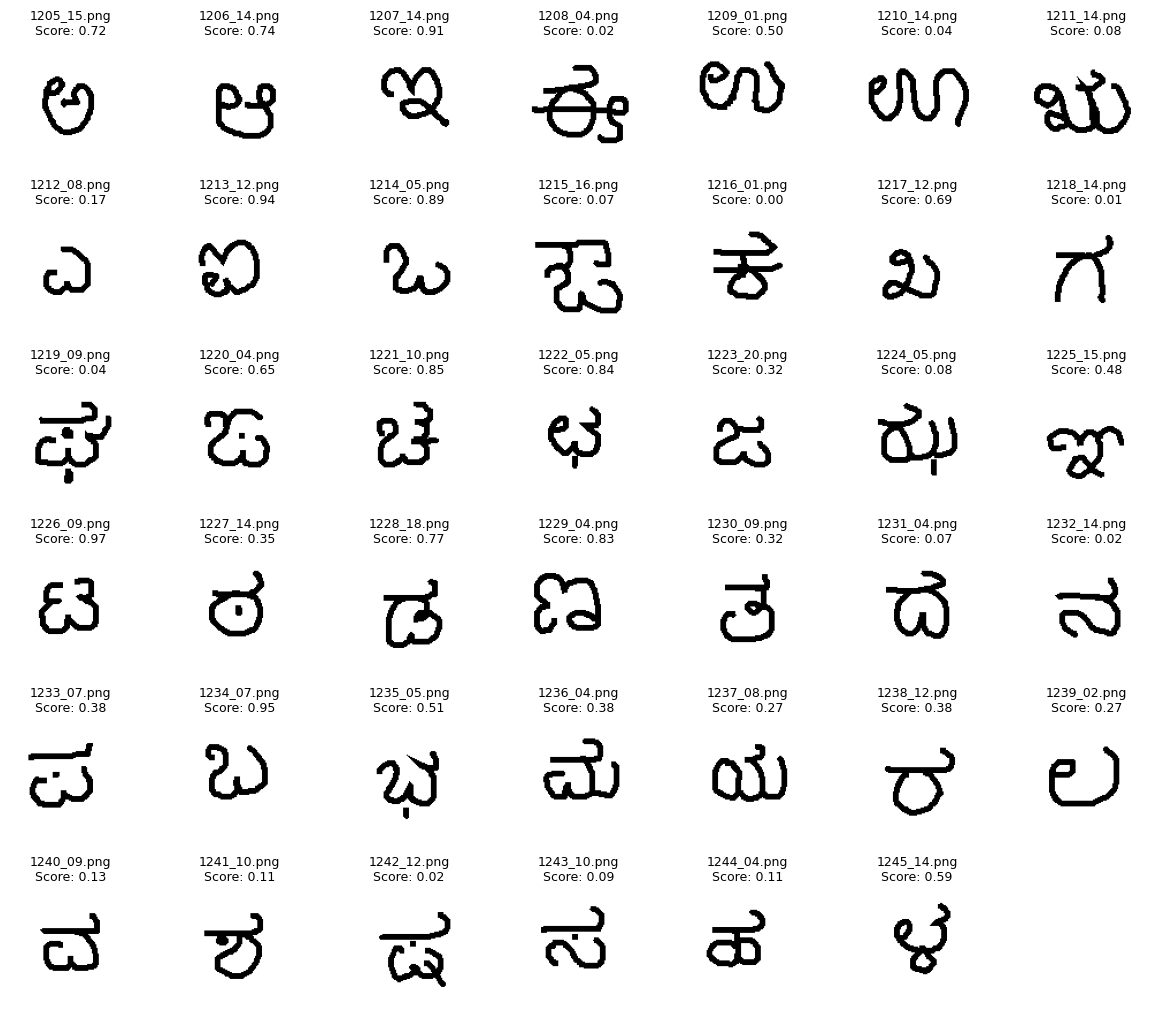

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model  # Ensure model is loaded

def load_and_preprocess_image(image_path, target_size=(105, 105)):
    """
    Loads a PNG image, converts it to grayscale, resizes it, and normalizes it.
    Returns: A processed NumPy array of shape (105, 105, 1)
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, target_size)  # Resize to match model input
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return np.expand_dims(image, axis=-1)  # Add channel dimension (105, 105, 1)

def load_support_set(support_folder, target_size=(105, 105)):
    """
    Loads all PNG images from the specified folder and preprocesses them.
    Returns: A NumPy array of shape (N, 105, 105, 1)
    """
    support_images = []
    filenames = sorted(os.listdir(support_folder))  # Sort for consistent ordering
    for filename in filenames:
        if filename.endswith('.png'):  # Load only PNG images
            img_path = os.path.join(support_folder, filename)
            img = load_and_preprocess_image(img_path, target_size)
            support_images.append(img)
    return np.array(support_images), filenames  # Return images and their names

def plot_support_set_vs_test(test_image_path, support_folder, model):
    """
    Compares a single test image against a support set of PNG images using a trained Siamese model.
    
    - test_image_path: Path to the test image (PNG).
    - support_folder: Folder containing the support images (PNG format).
    - model: Trained Siamese network model.
    """
    # Load test image
    test_image = load_and_preprocess_image(test_image_path)

    # Load support set images
    support_set, filenames = load_support_set(support_folder)

    # Ensure dimensions match (N, 105, 105, 1)
    N = support_set.shape[0]
    test_images = np.repeat(test_image[np.newaxis, ...], N, axis=0)  # Repeat test image

    # Get similarity scores from the model
    predictions = model.predict([test_images, support_set])

    # Find the index of the best match (highest score)
    best_index = np.argmax(predictions)

    # Plot images with similarity scores
    grid_size = int(np.ceil(np.sqrt(N)))  # Arrange in a square grid
    plt.figure(figsize=(12, 12))

    for i in range(N):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(support_set[i].reshape(105, 105), cmap='gray')
        plt.title(f"{filenames[i]}\nScore: {predictions[i][0]:.2f}", fontsize=9)
        plt.axis('off')

        # Highlight the best match in red
        if i == best_index:
            ax = plt.gca()
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

    return predictions

test_image_path = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1205_15.png"
support_folder = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets"  # Folder containing PNG images
predictions = plot_support_set_vs_test(test_image_path, support_folder, model)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


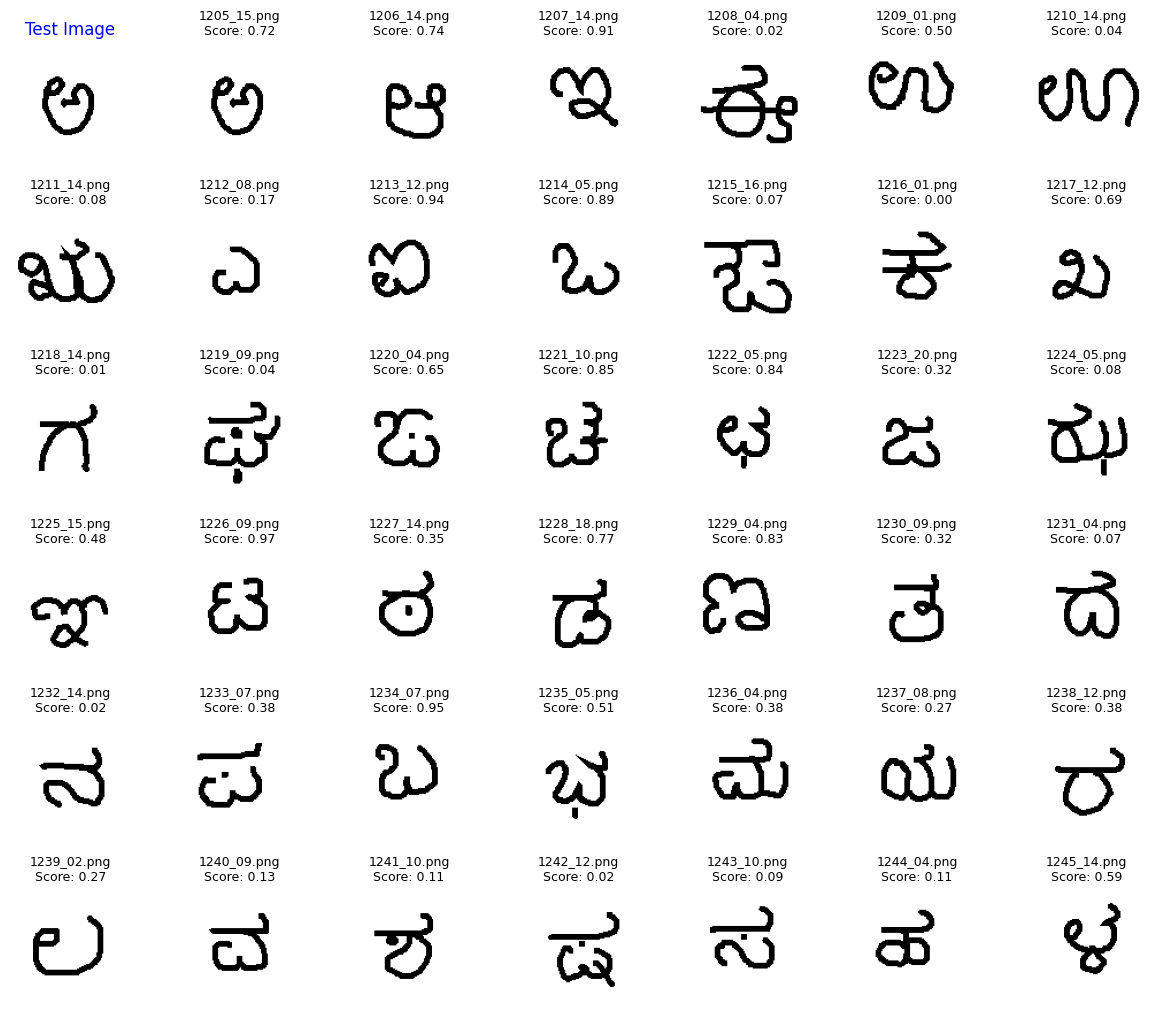

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model  

def load_and_preprocess_image(image_path, target_size=(105, 105)):
    """Loads, converts to grayscale, resizes, and normalizes the image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return np.expand_dims(image, axis=-1)  

def load_support_set(support_folder, target_size=(105, 105)):
    """Loads and preprocesses all PNG images from a folder."""
    support_images = []
    filenames = sorted(os.listdir(support_folder))
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(support_folder, filename)
            img = load_and_preprocess_image(img_path, target_size)
            support_images.append(img)
    return np.array(support_images), filenames

def plot_support_set_vs_test(test_image_path, support_folder, model):
    """Plots test image alongside support set with prediction scores."""
    # Load test image
    test_image = load_and_preprocess_image(test_image_path)

    # Load support images
    support_set, filenames = load_support_set(support_folder)

    N = len(support_set)  # Number of support images
    test_images = np.repeat(test_image[np.newaxis, ...], N, axis=0)  # Repeat test image

    # Get similarity scores from the model
    predictions = model.predict([test_images, support_set])

    # Find best match
    best_index = np.argmax(predictions)

    # Define grid size
    grid_size = int(np.ceil(np.sqrt(N + 1)))  

    plt.figure(figsize=(12, 12))

    # Plot the test image in the first position
    plt.subplot(grid_size, grid_size, 1)
    plt.imshow(test_image.reshape(105, 105), cmap='gray')
    plt.title("Test Image", fontsize=12, color='blue')
    plt.axis('off')

    # Plot support images with prediction scores
    for i in range(N):
        plt.subplot(grid_size, grid_size, i + 2)  
        plt.imshow(support_set[i].reshape(105, 105), cmap='gray')
        plt.title(f"{filenames[i]}\nScore: {predictions[i][0]:.2f}", fontsize=9)
        plt.axis('off')

        # Highlight best match in red
        if i == best_index:
            ax = plt.gca()
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

    return predictions

# Paths
test_image_path = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1205_15.png"
support_folder = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets"

# Run
predictions = plot_support_set_vs_test(test_image_path, support_folder, model)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


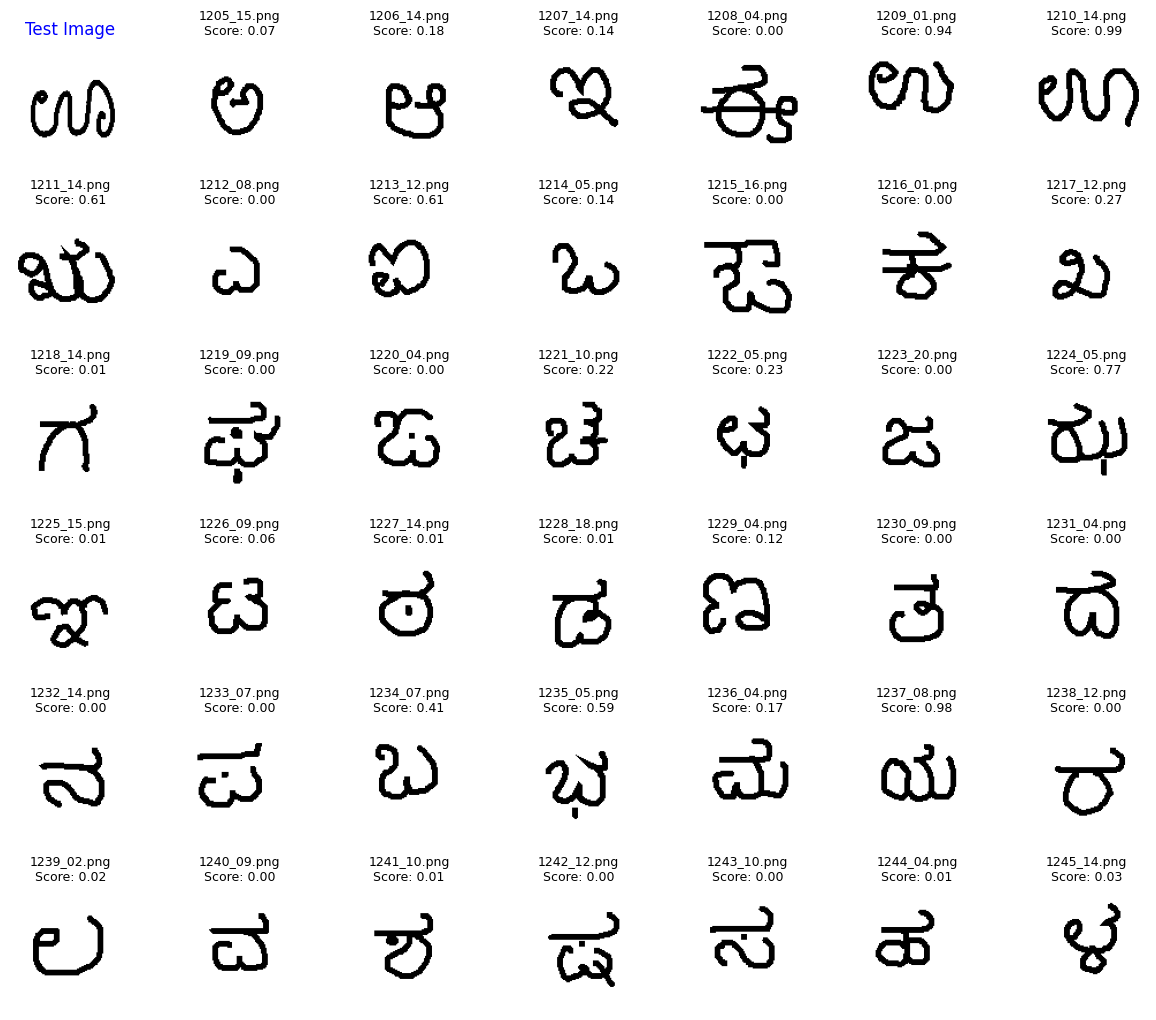

In [24]:
# Paths
test_image_path = "/kaggle/input/omniglot-siamese-trained/img006-023.png"
support_folder = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets"

# Run
predictions = plot_support_set_vs_test(test_image_path, support_folder, model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


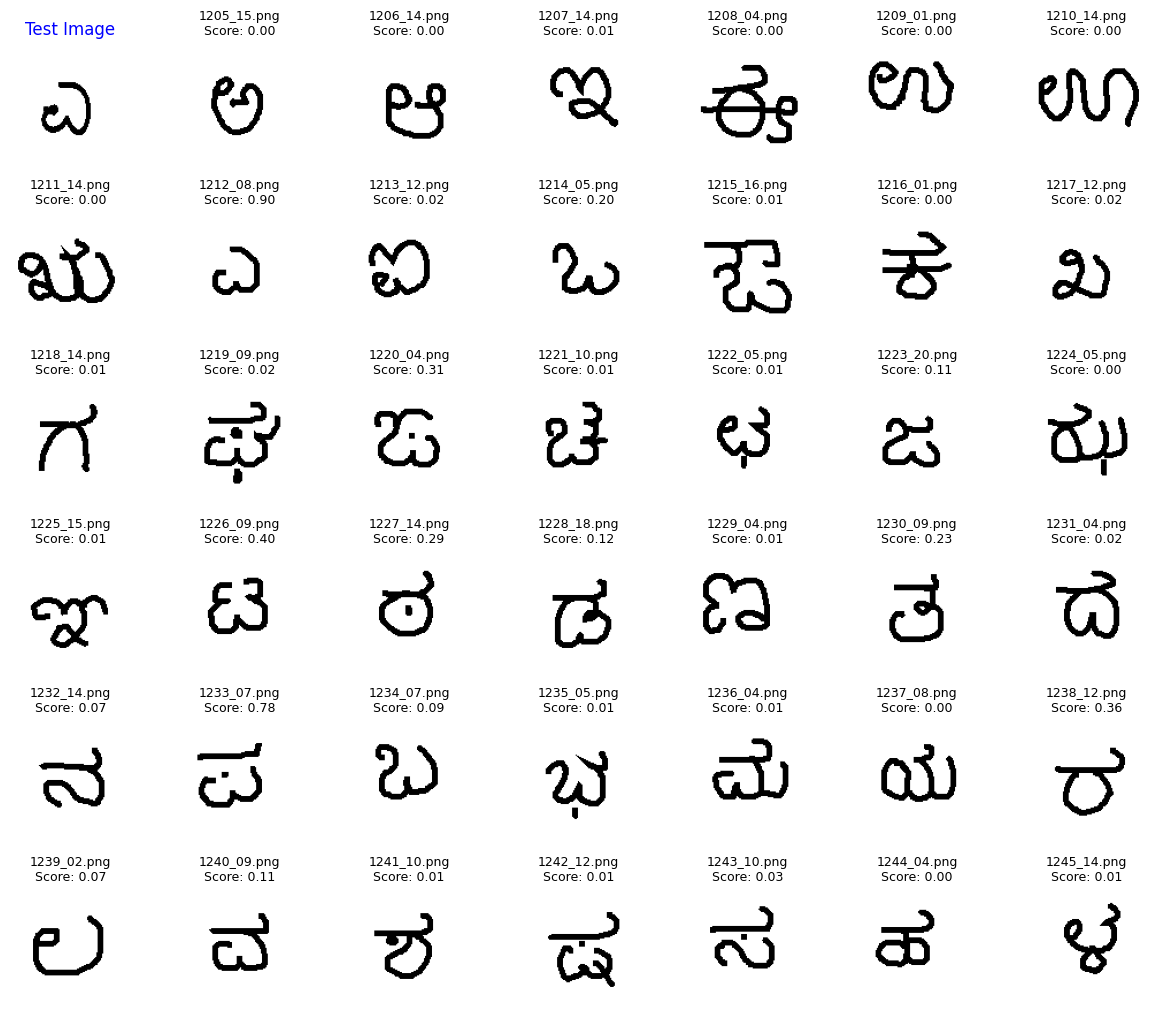

In [26]:
# Paths
test_image_path = "/kaggle/input/omniglot-siamese-trained/img009-012.png"
support_folder = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets"

# Run
predictions = plot_support_set_vs_test(test_image_path, support_folder, model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


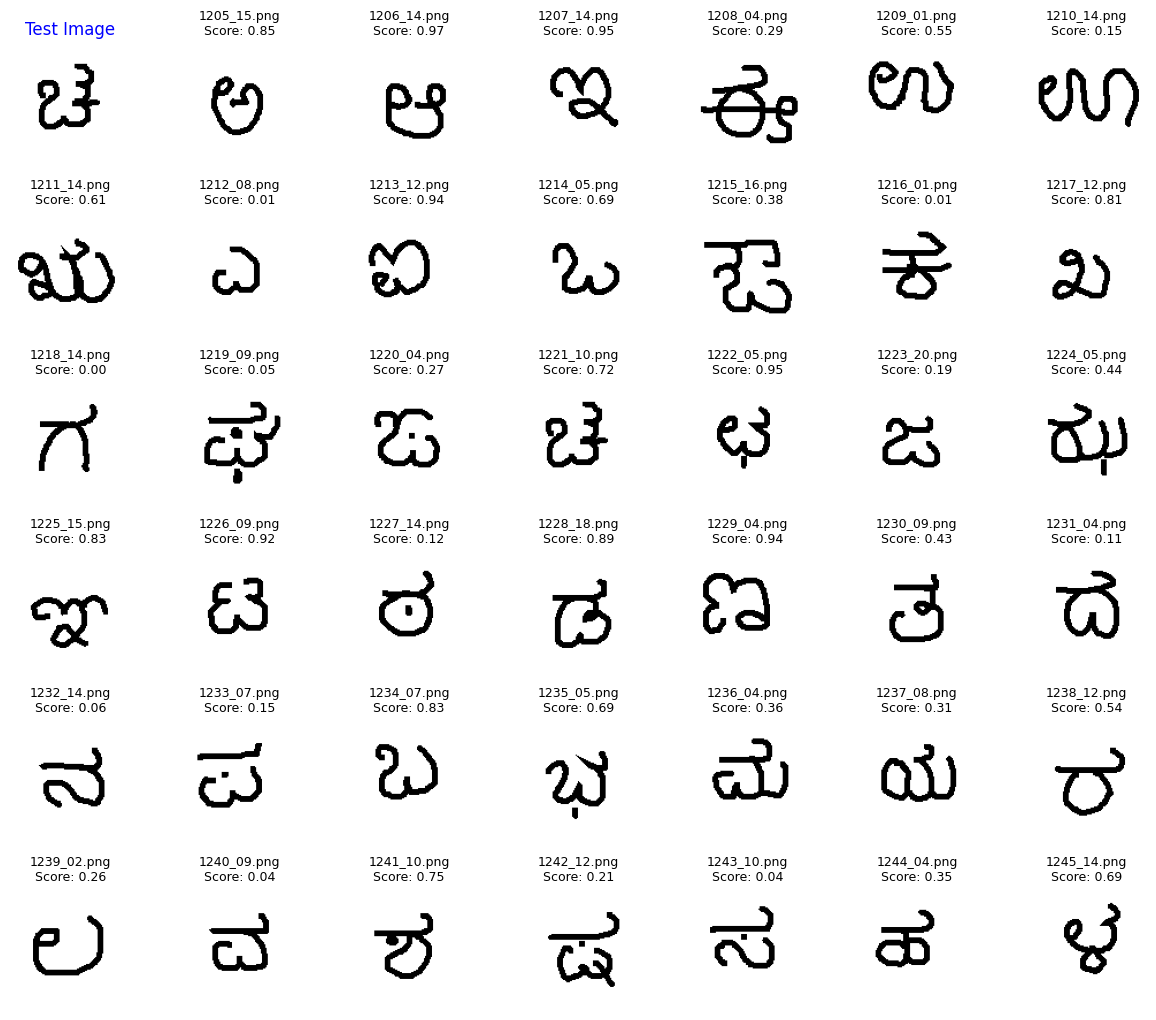

In [27]:
# Paths
test_image_path = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets/1221_10.png"
support_folder = "/kaggle/input/omniglot-siamese-trained/Kannada_Alphabets"

# Run
predictions = plot_support_set_vs_test(test_image_path, support_folder, model)